In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os

# Path to video
video_path = '/content/drive/MyDrive/sewer/3225.mp4'

# Load the video
cap = cv2.VideoCapture(video_path)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Extract metadata
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = int(fps)
    duration = frame_count / fps if fps > 0 else 0

    print("📄 Video Metadata:")
    print(f"▶️ Frame rate (FPS): {fps}")
    print(f"🖼️ Frame resolution: {width} x {height}")
    print(f"📦 Total frames: {frame_count}")
    print(f"⏱️ Duration: {duration:.2f} seconds")
    print(f"📁 File size: {os.path.getsize(video_path) / (1024*1024):.2f} MB")



Error: Could not open video.


In [ ]:
duration = frame_count / fps
print(f"Extracting 1 frame per second from {duration:.2f} sec video (~{int(duration)} frames)")


NameError: name 'frame_count' is not defined

In [ ]:
output_dir = "/content/drive/MyDrive/sewer/sewer_frames"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
data = []
frame_idx = 0
saved_frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % frame_interval == 0:
        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Image metrics
            sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
            brightness = np.mean(gray)
            contrast_std = np.std(gray)
            contrast_range = np.max(gray) - np.min(gray)
            noise = np.mean(np.abs(cv2.Laplacian(gray, cv2.CV_64F)))
            hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
            hist_norm = hist.ravel() / hist.sum()
            entropy_val = entropy(hist_norm + 1e-8)
            corners = cv2.goodFeaturesToTrack(gray, maxCorners=500, qualityLevel=0.01, minDistance=10)
            corner_count = 0 if corners is None else len(corners)

            # Save frame
            filename = f"frame_{saved_frame_idx:05d}.jpg"
            cv2.imwrite(os.path.join(output_dir, filename), frame)

            # Save metrics
            data.append({
                "frame_id": filename,
                "sharpness": sharpness,
                "brightness": brightness,
                "contrast_std": contrast_std,
                "contrast_range": contrast_range,
                "noise": noise,
                "entropy": entropy_val,
                "corner_count": corner_count
            })

            saved_frame_idx += 1
        except Exception as e:
            print(f"Error at frame {frame_idx}: {e}")

    frame_idx += 1

cap.release()

In [ ]:
df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/sewer/sewer_frame_metrics.csv", index=False)
print("✅ Frame metrics saved to /content/drive/MyDrive/sewer/sewer_frame_metrics.csv")

✅ Frame metrics saved to /content/drive/MyDrive/sewer/sewer_frame_metrics.csv


In [ ]:
df.head()

,frame_id,sharpness,brightness,contrast_std,contrast_range,noise,entropy,corner_count
0,frame_00000.jpg,146.100785,150.771817,56.151550,255,8.094393,5.155320,500
1,frame_00001.jpg,145.912154,150.803785,56.156793,255,8.091611,5.156727,500
2,frame_00002.jpg,145.773382,150.832275,56.156248,255,8.085505,5.155749,500
3,frame_00003.jpg,145.562811,150.828768,56.149068,255,8.078444,5.154981,500
4,frame_00004.jpg,145.376353,150.751824,56.099153,255,8.070405,5.154445,500


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/sewer/sewer_frame_metrics.csv")  # Replace with your file path

# Basic statistical summary
summary = data.describe()

# Display the summary
print("📊 Statistical Summary:")
print(summary)

📊 Statistical Summary:
        sharpness  brightness  contrast_std  contrast_range       noise  \
count  557.000000  557.000000    557.000000      557.000000  557.000000   
mean   151.788486  137.732282     62.946726      253.538600    6.998532   
std     68.559092   21.542716     10.312305        7.435384    1.838669   
min     34.665177   25.544719     23.226690      182.000000    2.016872   
25%    116.057997  130.801288     57.575971      255.000000    6.164945   
50%    129.389351  137.945445     60.011227      255.000000    6.816618   
75%    174.181496  146.171436     64.922544      255.000000    7.623597   
max    615.974224  245.815410    104.261070      255.000000   15.125245   

          entropy  corner_count  
count  557.000000    557.000000  
mean     5.082035    499.538600  
std      0.361936      8.224636  
min      1.600718    323.000000  
25%      5.017824    500.000000  
50%      5.108685    500.000000  
75%      5.282881    500.000000  
max      5.466482    500.0000

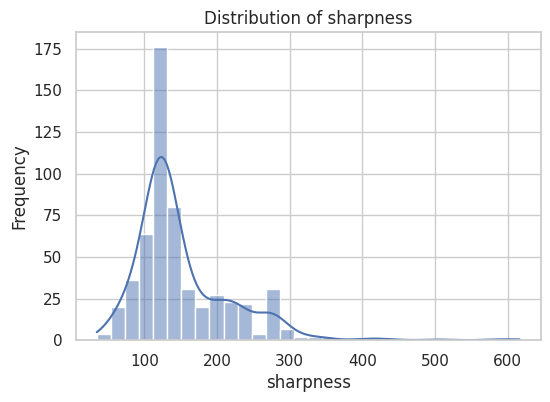

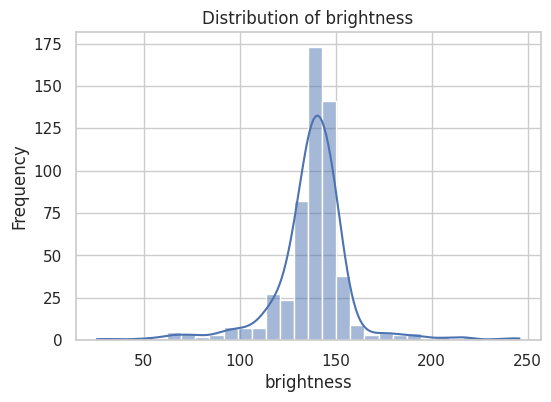

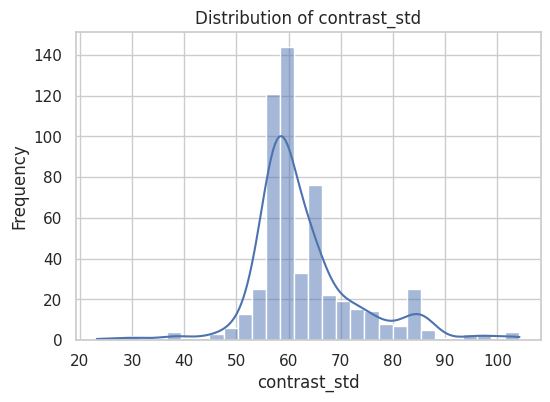

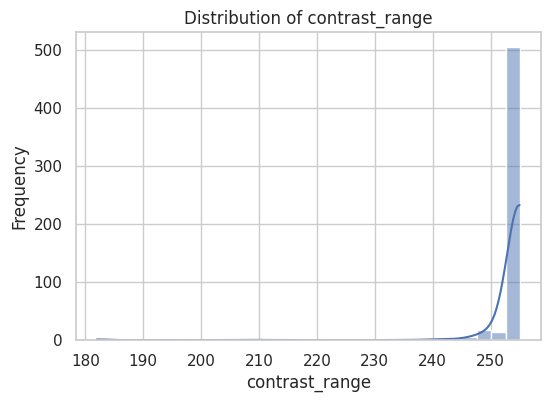

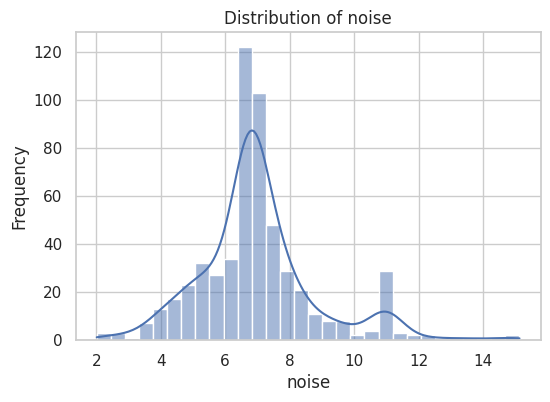

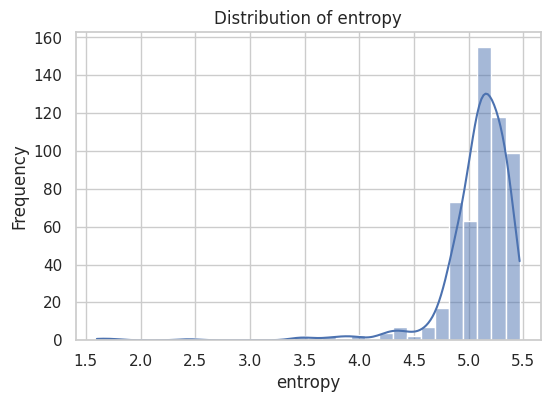

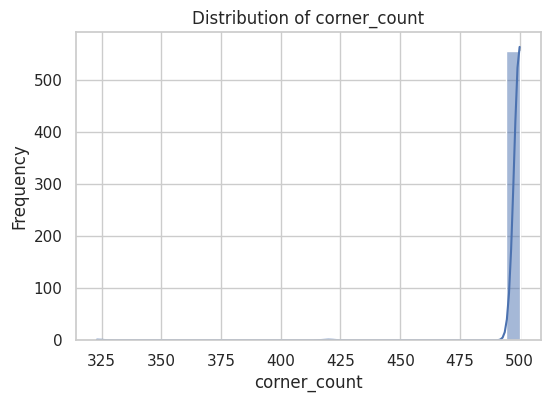

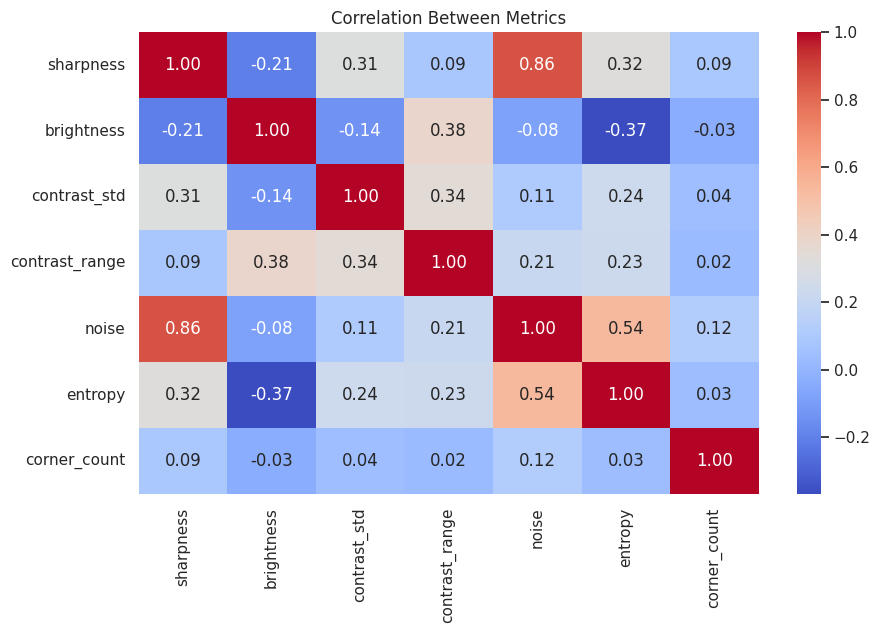

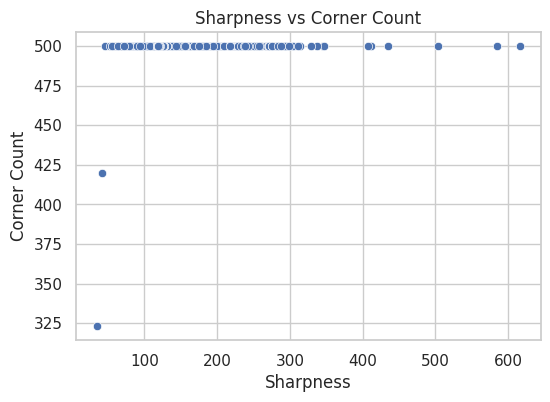

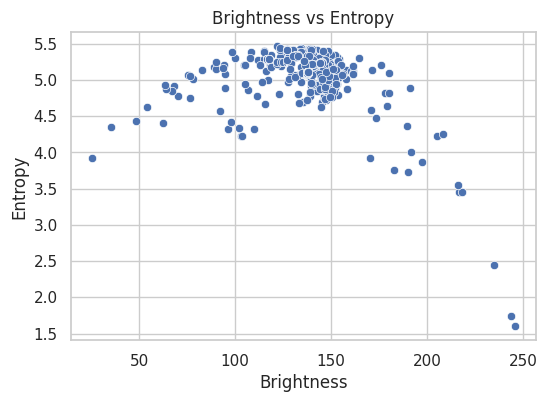

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("/content/drive/MyDrive/sewer/sewer_frame_metrics.csv")

# Set style
sns.set(style="whitegrid")

# 1. Histograms
metrics = ["sharpness", "brightness", "contrast_std", "contrast_range", "noise", "entropy", "corner_count"]

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[metric], bins=30, kde=True)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[metrics].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Metrics")
plt.show()

# 3. Scatter: Sharpness vs Corner Count
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="sharpness", y="corner_count")
plt.title("Sharpness vs Corner Count")
plt.xlabel("Sharpness")
plt.ylabel("Corner Count")
plt.show()

# 4. Scatter: Brightness vs Entropy
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="brightness", y="entropy")
plt.title("Brightness vs Entropy")
plt.xlabel("Brightness")
plt.ylabel("Entropy")
plt.show()


# Colmap

In [ ]:
# First, update
!sudo apt-get update

# Install basic development libraries
!sudo apt-get install -y \
    git cmake ninja-build build-essential \
    libboost-program-options-dev libboost-graph-dev libboost-system-dev \
    libeigen3-dev libflann-dev libfreeimage-dev libmetis-dev \
    libgoogle-glog-dev libgtest-dev libgmock-dev libsqlite3-dev \
    libglew-dev qtbase5-dev libqt5opengl5-dev libcgal-dev libceres-dev

# Install OpenGL libraries
!sudo apt-get install -y libgl1-mesa-dev libglu1-mesa-dev


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,729 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:13 http://security.ubunt

In [ ]:
# 1. Clone COLMAP
!git clone https://github.com/colmap/colmap.git

# 2. Enter COLMAP directory
%cd colmap

# 3. Create and move into 'build' directory
!mkdir build
%cd build

# 4. Run cmake
!cmake .. -GNinja

# 5. Compile using ninja
!ninja

# 6. Install system-wide
!sudo ninja install


Cloning into 'colmap'...
remote: Enumerating objects: 28050, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 28050 (delta 335), reused 273 (delta 217), pack-reused 27589 (from 2)
Receiving objects: 100% (28050/28050), 71.01 MiB | 26.16 MiB/s, done.
Resolving deltas: 100% (21597/21597), done.
/content/colmap
/content/colmap/build
-- Enabling LSD support
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found FreeImage
--   Includes : /usr/include
--   Libraries : /usr

In [ ]:
# Create backup directory
!mkdir -p /content/drive/MyDrive/colmap_backup/bin
!mkdir -p /content/drive/MyDrive/colmap_backup/lib
!mkdir -p /content/drive/MyDrive/colmap_backup/include
!mkdir -p /content/drive/MyDrive/colmap_backup/share

# Backup the executable
!cp /usr/local/bin/colmap /content/drive/MyDrive/colmap_backup/bin/

# Backup libraries
!cp /usr/local/lib/libcolmap* /content/drive/MyDrive/colmap_backup/lib/

# Backup headers
!cp -r /usr/local/include/colmap /content/drive/MyDrive/colmap_backup/include/

# Backup shared config
!cp -r /usr/local/share/colmap /content/drive/MyDrive/colmap_backup/share/


In [ ]:
!unzip -q "/content/drive/MyDrive/sewer/images_1-20250519T161233Z-1-001.zip" -d "/content/drive/MyDrive/sewer/sfm"

In [ ]:
# 1. Copy COLMAP binary back
!sudo cp /content/drive/MyDrive/colmap_backup/bin/colmap /usr/local/bin/

# 2. Copy COLMAP libraries
!sudo cp /content/drive/MyDrive/colmap_backup/lib/libcolmap* /usr/local/lib/

# 3. Copy COLMAP headers
!sudo cp -r /content/drive/MyDrive/colmap_backup/include/colmap /usr/local/include/

# 4. Copy COLMAP CMake files
!sudo cp -r /content/drive/MyDrive/colmap_backup/share/colmap /usr/local/share/

# 5. Update linker cache (important!)
!sudo ldconfig


/sbin/ldconfig.real: /usr/local/lib/libumf.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libhwloc.so.15 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is

In [ ]:
!du -sh /content/drive/MyDrive/colmap_backup


119M	/content/drive/MyDrive/colmap_backup


In [ ]:
!chmod +x /usr/local/bin/colmap


In [ ]:
!mkdir -p /content/drive/MyDrive/sewer/colmap_workspace/sparse
!mkdir -p /content/drive/MyDrive/sewer/colmap_workspace/dense


In [ ]:
!colmap feature_extractor \
    --database_path /content/drive/MyDrive/sewer/colmap_workspace/database.db \
    --image_path /content/drive/MyDrive/sewer/sfm/images_1/ \
    --ImageReader.single_camera 1 \
    --SiftExtraction.use_gpu 0


W0526 20:31:03.981520 18035 feature_extraction.cc:403] Your current options use the maximum number of threads on the machine to extract features. Extracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.
I0526 20:31:03.982036 18037 misc.cc:44] 
Feature extraction
I0526 20:31:03.983091 18040 sift.cc:727] Creating SIFT CPU feature extractor
I0526 20:31:03.983182 18041 sift.cc:727] Creating SIFT CPU feature extractor
I0526 20:31:19.756161 18042 feature_extraction.cc:259] Processed file [1/240]
I0526 20:31:19.756276 18042 feature_extraction.cc:262]   Name:            frame_0002.png
I0526 20:31:19.756286 18042 feature_extraction.cc:271]   Dimensions:      1920 x 1080
I0526 20:31:19.756295 18042 feature_extraction.cc:274]   Camera:          #1 - SIMPLE_RADIAL
I0

In [ ]:
!colmap sequential_matcher \
    --database_path /content/drive/MyDrive/sewer/colmap_workspace/database.db \
    --SiftMatching.use_gpu 0


I0526 20:55:35.649109 24128 misc.cc:44] 
Feature matching
I0526 20:55:35.708034 24134 sift.cc:1432] Creating SIFT CPU feature matcher
I0526 20:55:35.716998 24133 sift.cc:1432] Creating SIFT CPU feature matcher
I0526 20:55:35.717139 24128 pairing.cc:397] Generating sequential image pairs...
I0526 20:55:35.729907 24128 pairing.cc:455] Matching image [1/240]
I0526 20:55:49.390810 24128 feature_matching.cc:46] in 13.661s
I0526 20:55:49.398137 24128 pairing.cc:455] Matching image [2/240]
I0526 20:56:01.480942 24128 feature_matching.cc:46] in 12.083s
I0526 20:56:01.487370 24128 pairing.cc:455] Matching image [3/240]
I0526 20:56:10.524487 24128 feature_matching.cc:46] in 9.037s
I0526 20:56:10.531594 24128 pairing.cc:455] Matching image [4/240]
I0526 20:56:22.340129 24128 feature_matching.cc:46] in 11.809s
I0526 20:56:22.348712 24128 pairing.cc:455] Matching image [5/240]
I0526 20:56:34.567328 24128 feature_matching.cc:46] in 12.219s
I0526 20:56:34.572811 24128 pairing.cc:455] Matching image [

In [ ]:
!colmap mapper \
    --database_path /content/drive/MyDrive/sewer/colmap_workspace/database.db \
    --image_path /content/drive/MyDrive/sewer/sfm/images_1/ \
    --output_path /content/drive/MyDrive/sewer/colmap_workspace/sparse


I0526 21:32:42.380474 33076 incremental_pipeline.cc:253] Loading database
I0526 21:32:42.533851 33076 database_cache.cc:69] Loading rigs...
I0526 21:32:42.533948 33076 database_cache.cc:79]  1 in 0.000s
I0526 21:32:42.533972 33076 database_cache.cc:87] Loading cameras...
I0526 21:32:42.533995 33076 database_cache.cc:105]  1 in 0.000s
I0526 21:32:42.534008 33076 database_cache.cc:113] Loading frames...
I0526 21:32:42.540139 33076 database_cache.cc:130]  240 in 0.006s
I0526 21:32:42.540197 33076 database_cache.cc:138] Loading matches...
I0526 21:32:42.603124 33076 database_cache.cc:143]  1665 in 0.063s
I0526 21:32:42.603179 33076 database_cache.cc:159] Loading images...
I0526 21:32:43.039433 33076 database_cache.cc:241]  240 in 0.436s (connected 240)
I0526 21:32:43.039525 33076 database_cache.cc:252] Building correspondence graph...
I0526 21:32:43.469440 33076 database_cache.cc:279]  in 0.430s (ignored 0)
I0526 21:32:43.470091 33076 timer.cc:91] Elapsed time: 0.016 [minutes]
I0526 21:32:

In [ ]:
%cd /content/drive/MyDrive/sewer/sfm/images_1/

/content/drive/MyDrive/sewer/sfm/images_1


In [ ]:
!colmap image_undistorter \
    --image_path /content/drive/MyDrive/sewer/sfm/images_1/ \
    --input_path /content/drive/MyDrive/sewer/colmap_workspace/sparse/0 \
    --output_path /content/drive/MyDrive/sewer/colmap_workspace/dense \
    --output_type COLMAP \
    --max_image_size 2000


I0526 21:57:31.625254 39104 misc.cc:44] 
Reading reconstruction
I0526 21:57:31.644352 39104 image.cc:361] => Reconstruction with 2 images and 81 points
I0526 21:57:31.644439 39104 misc.cc:44] 
Image undistortion
I0526 21:57:31.661720 39104 undistortion.cc:215] Undistorting image [1/2]
I0526 21:57:33.209560 39104 undistortion.cc:215] Undistorting image [2/2]
I0526 21:57:33.215165 39104 undistortion.cc:225] Writing reconstruction...
I0526 21:57:33.270676 39104 undistortion.cc:230] Writing configuration...
I0526 21:57:33.286937 39104 undistortion.cc:234] Writing scripts...
I0526 21:57:33.302203 39104 timer.cc:91] Elapsed time: 0.028 [minutes]


In [ ]:
!colmap patch_match_stereo \
    --workspace_path /content/drive/MyDrive/sewer/colmap_workspace/dense \
    --workspace_format COLMAP \
    --PatchMatchStereo.geom_consistency true \
    --PatchMatchStereo.gpu_index 0


I0527 00:13:05.294559 71924 patch_match.cc:205] Reading workspace...
I0527 00:13:05.312239 71924 patch_match.cc:235] Reading configuration...
I0527 00:13:05.314409 71924 patch_match.cc:366] Configuration has 2 problems...
I0527 00:13:05.315807 71926 misc.cc:44] 
Processing view 1 / 2 for frame_0316.png
I0527 00:13:05.315843 71926 patch_match.cc:461] Reading inputs...
I0527 00:13:05.380600 71926 misc.cc:51] 
PatchMatch::Problem
-------------------
I0527 00:13:05.380642 71926 patch_match.cc:54] ref_image_idx: 0
I0527 00:13:05.380650 71926 patch_match.cc:55] src_image_idxs: 
I0527 00:13:05.380657 71926 patch_match.cc:60] 1
I0527 00:13:05.380679 71926 misc.cc:51] 
PatchMatchOptions
-----------------
I0527 00:13:05.380687 71926 patch_match_options.cc:47] max_image_size: -1
I0527 00:13:05.380694 71926 patch_match_options.cc:48] gpu_index: 0
I0527 00:13:05.380702 71926 patch_match_options.cc:49] depth_min: 7.71743
I0527 00:13:05.380743 71926 patch_match_options.cc:50] depth_max: 14.8254
I0527

In [ ]:
!colmap stereo_fusion \
    --workspace_path /content/drive/MyDrive/sewer/colmap_workspace/dense \
    --workspace_format COLMAP \
    --input_type photometric \
    --output_path /content/drive/MyDrive/sewer/colmap_workspace/dense/fused.ply


I0526 21:57:33.658099 39118 misc.cc:51] 
StereoFusion::Options
---------------------
I0526 21:57:33.658211 39118 fusion.cc:76] mask_path: 
I0526 21:57:33.658222 39118 fusion.cc:77] max_image_size: -1
I0526 21:57:33.658229 39118 fusion.cc:78] min_num_pixels: 5
I0526 21:57:33.658236 39118 fusion.cc:79] max_num_pixels: 10000
I0526 21:57:33.658242 39118 fusion.cc:80] max_traversal_depth: 100
I0526 21:57:33.658249 39118 fusion.cc:81] max_reproj_error: 2
I0526 21:57:33.658267 39118 fusion.cc:82] max_depth_error: 0.01
I0526 21:57:33.658277 39118 fusion.cc:83] max_normal_error: 10
I0526 21:57:33.658286 39118 fusion.cc:84] check_num_images: 50
I0526 21:57:33.658293 39118 fusion.cc:85] use_cache: 0
I0526 21:57:33.658299 39118 fusion.cc:86] cache_size: 32
I0526 21:57:33.658308 39118 fusion.cc:89] bbox_min: -3.40282e+38 -3.40282e+38 -3.40282e+38
I0526 21:57:33.658331 39118 fusion.cc:90] bbox_max: 3.40282e+38 3.40282e+38 3.40282e+38
I0526 21:57:33.658350 39118 fusion.cc:140] Reading workspace...
I0

In [ ]:
!pip install open3d -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00


[Open3D WARNING] Read PLY failed: number of vertex <= 0.


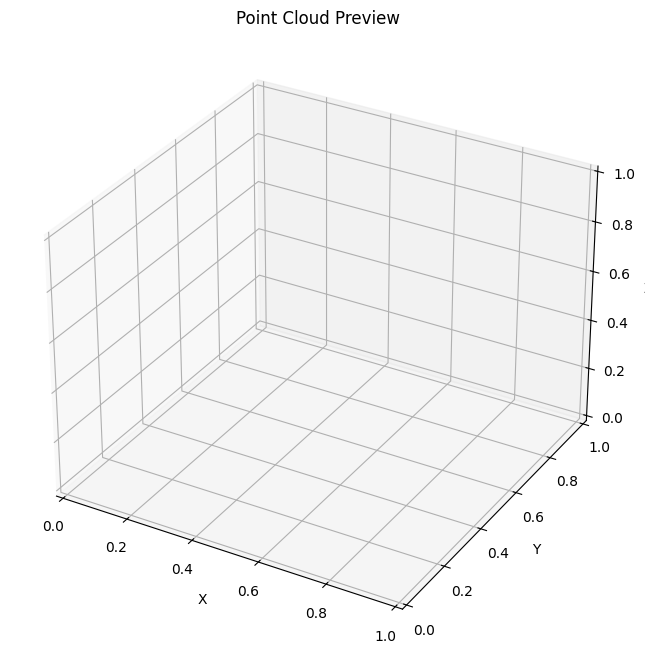

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the point cloud
ply_path = "/content/drive/MyDrive/sewer/colmap_workspace/dense/fused.ply"
pcd = o3d.io.read_point_cloud(ply_path)

# Convert points to numpy array
points = np.asarray(pcd.points)

# Plot using matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Downsample if too many points
sample = points[::50]  # take every 50th point

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud Preview')
plt.show()


In [ ]:
import open3d as o3d

# Load point cloud
pcd = o3d.io.read_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/fused.ply")

# Remove outliers
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

pcd_clean = pcd.select_by_index(ind)

# Save
o3d.io.write_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/clean_fused.ply", pcd_clean)


[Open3D WARNING] Read PLY failed: number of vertex <= 0.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.


False

In [ ]:
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_clean, depth=9)

o3d.io.write_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/mesh_fused.ply", mesh)

RuntimeError: [1;31m[Open3D Error] (static std::tuple<std::shared_ptr<open3d::geometry::TriangleMesh>, std::vector<double, std::allocator<double> > > open3d::geometry::TriangleMesh::CreateFromPointCloudPoisson(const open3d::geometry::PointCloud&, size_t, float, float, bool, int)) /root/Open3D/cpp/open3d/geometry/SurfaceReconstructionPoisson.cpp:731: Point cloud has no normals
[0;m

[Open3D WARNING] Read PLY failed: unable to open file: /content/drive/MyDrive/sewer/colmap_workspace/dense/mesh_fused.ply


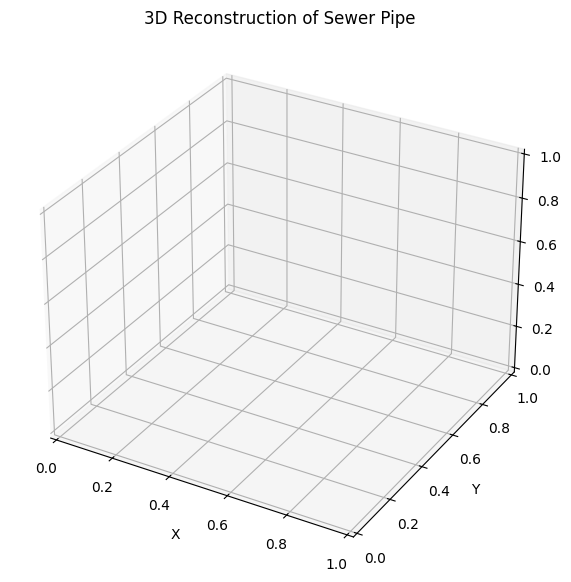

In [ ]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np

mesh = o3d.io.read_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/mesh_fused.ply")

vertices = np.asarray(mesh.vertices)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("3D Reconstruction of Sewer Pipe")
plt.show()


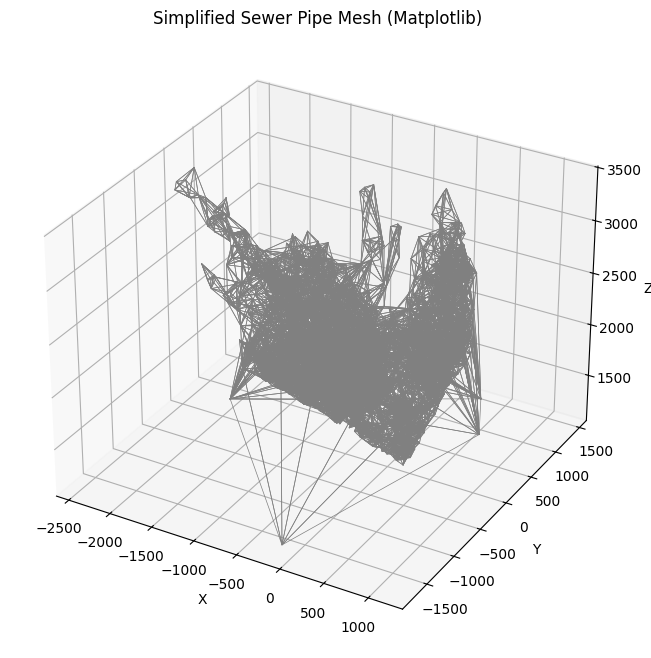

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load mesh
mesh = o3d.io.read_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/mesh_fused.ply")

# Aggressive simplification (only ~1000 triangles)
mesh = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
mesh.compute_vertex_normals()

# Get vertices and triangles
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Plot with Matplotlib (safe, no OpenGL)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw each triangle
for tri in triangles:
    pts = vertices[tri]
    tri_verts = np.vstack([pts, pts[0]])  # close the triangle
    ax.plot(tri_verts[:, 0], tri_verts[:, 1], tri_verts[:, 2], color="gray", linewidth=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Simplified Sewer Pipe Mesh (Matplotlib)")
plt.show()


In [ ]:
import open3d as o3d
import numpy as np

# Load the cleaned mesh or point cloud
pcd = o3d.io.read_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/clean_fused.ply")

# Optional: Visualize raw points
# o3d.visualization.draw_geometries([pcd])

# Crop: based on bounding box
bbox = o3d.geometry.AxisAlignedBoundingBox(
    min_bound=(-1500, -1500, 1000),
    max_bound=(1500, 1500, 4000)
)

pcd_cropped = pcd.crop(bbox)

# Save cropped version
o3d.io.write_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/cropped_sewer.ply", pcd_cropped)

print("✅ Cropped point cloud saved!")


✅ Cropped point cloud saved!


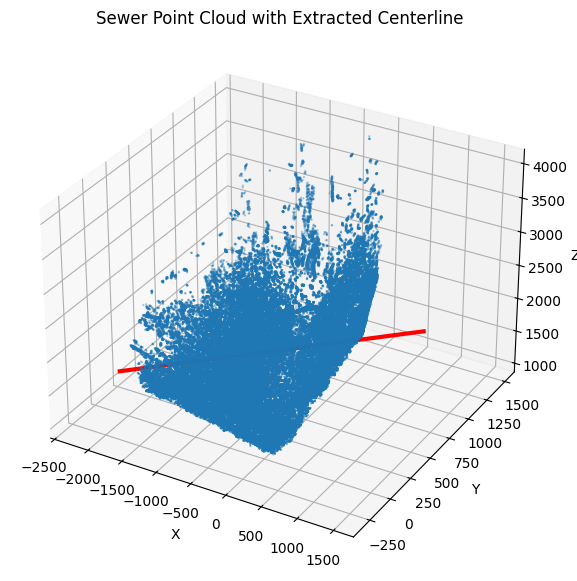

✅ Centerline estimated and plotted!


In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load cropped point cloud
pcd = o3d.io.read_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/cropped_sewer.ply")
points = np.asarray(pcd.points)

# Perform PCA
pca = PCA(n_components=3)
pca.fit(points)

# Principal components
center = np.mean(points, axis=0)
direction = pca.components_[0]

# Create a line along the main axis
t = np.linspace(-2000, 2000, 100)  # adjust range if needed
line_points = center + np.outer(t, direction)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.5, alpha=0.3)
ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], color='red', linewidth=3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Sewer Point Cloud with Extracted Centerline")
plt.show()

print("✅ Centerline estimated and plotted!")


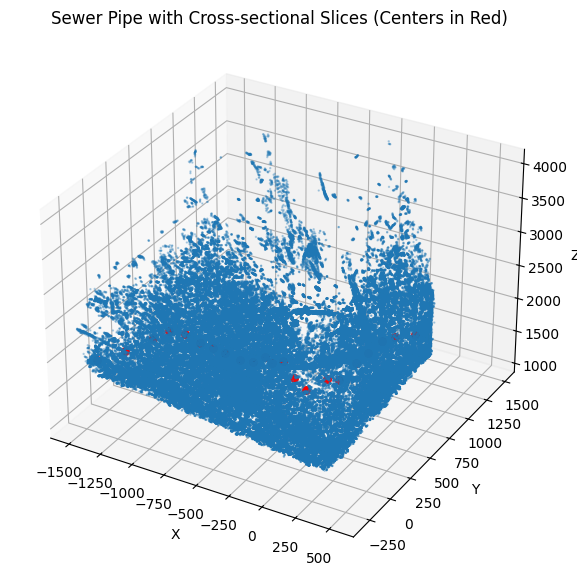

✅ Cross-sectional slices plotted!


In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load cropped point cloud
pcd = o3d.io.read_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/cropped_sewer.ply")
points = np.asarray(pcd.points)

# Perform PCA
pca = PCA(n_components=3)
pca.fit(points)
center = np.mean(points, axis=0)
main_direction = pca.components_[0]

# Projection along the pipe axis
projections = np.dot(points - center, main_direction)

# Define slices
slice_thickness = 100  # units (adjustable)
slice_centers = np.arange(projections.min(), projections.max(), slice_thickness)

# Prepare plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.5, alpha=0.3)

# Extract and plot slices
for sc in slice_centers:
    mask = (projections > sc - slice_thickness/2) & (projections < sc + slice_thickness/2)
    slice_points = points[mask]

    if len(slice_points) > 10:  # Only plot if enough points
        slice_center = slice_points.mean(axis=0)
        ax.scatter(slice_center[0], slice_center[1], slice_center[2], color='red', s=30)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Sewer Pipe with Cross-sectional Slices (Centers in Red)")
plt.show()

print("✅ Cross-sectional slices plotted!")


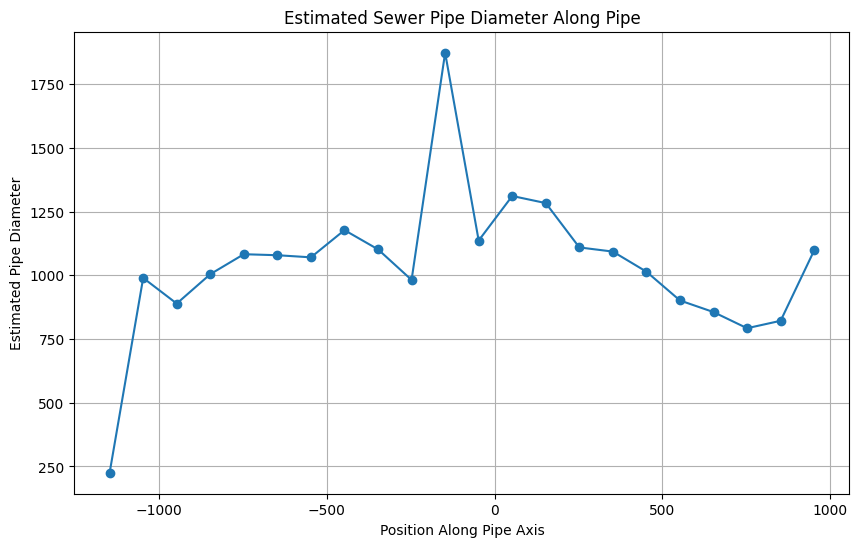

✅ Fitted circles and plotted diameter!


In [ ]:
from scipy.optimize import least_squares

def fit_circle_2d(points):
    # Initial guess
    x_m = np.mean(points[:, 0])
    y_m = np.mean(points[:, 1])

    def calc_R(xc, yc):
        return np.sqrt((points[:,0] - xc)**2 + (points[:,1] - yc)**2)

    def cost(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    res = least_squares(cost, x0=[x_m, y_m])
    center = res.x
    radius = calc_R(*center).mean()
    return center, radius

# Slice parameters
slice_thickness = 100
slice_centers = np.arange(projections.min(), projections.max(), slice_thickness)

# Store diameters
slice_positions = []
slice_radii = []

# Process each slice
for sc in slice_centers:
    mask = (projections > sc - slice_thickness/2) & (projections < sc + slice_thickness/2)
    slice_points = points[mask]

    if len(slice_points) > 30:  # only if enough points
        # Project points onto plane
        proj_points = slice_points - np.outer(np.dot(slice_points - center, main_direction), main_direction)

        # Get 2D coordinates
        u = pca.components_[1]
        v = pca.components_[2]
        coords_2d = np.stack([
            np.dot(proj_points, u),
            np.dot(proj_points, v)
        ], axis=-1)

        center2d, radius = fit_circle_2d(coords_2d)

        slice_positions.append(sc)
        slice_radii.append(radius)

# Plot radius along pipe
plt.figure(figsize=(10,6))
plt.plot(slice_positions, np.array(slice_radii)*2, marker='o')
plt.xlabel("Position Along Pipe Axis")
plt.ylabel("Estimated Pipe Diameter")
plt.title("Estimated Sewer Pipe Diameter Along Pipe")
plt.grid()
plt.show()

print("✅ Fitted circles and plotted diameter!")


In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Load the clean point cloud again
pcd_clean = o3d.io.read_point_cloud("/content/drive/MyDrive/sewer/colmap_workspace/dense/clean_fused.ply")
points = np.asarray(pcd_clean.points)

# Create slices along Z axis
slice_thickness = 200  # adjust as needed
z_min, z_max = points[:, 2].min(), points[:, 2].max()
slices = []
centers = []
diameters = []

for z in np.arange(z_min, z_max, slice_thickness):
    mask = (points[:, 2] > z) & (points[:, 2] <= z + slice_thickness)
    slice_pts = points[mask]
    if len(slice_pts) > 20:
        slices.append(slice_pts)
        center = slice_pts[:, :2].mean(axis=0)
        distances = np.linalg.norm(slice_pts[:, :2] - center, axis=1)
        estimated_radius = np.median(distances)
        centers.append([center[0], center[1], z + slice_thickness / 2])
        diameters.append(2 * estimated_radius)

centers = np.array(centers)
diameters = np.array(diameters)

# Save them for future use
np.save("/content/drive/MyDrive/sewer/colmap_workspace/dense/centers.npy", centers)
np.save("/content/drive/MyDrive/sewer/colmap_workspace/dense/diameters.npy", diameters)

print(f"✅ Recreated {len(centers)} center points and diameters!")


✅ Recreated 22 center points and diameters!


In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Load centers and diameters
centers = np.load("/content/drive/MyDrive/sewer/colmap_workspace/dense/centers.npy")
diameters = np.load("/content/drive/MyDrive/sewer/colmap_workspace/dense/diameters.npy")

# Parameters
num_circle_points = 30  # number of points in each circular cross-section

# Generate vertices
vertices = []
faces = []

for i, (center, diameter) in enumerate(zip(centers, diameters)):
    radius = diameter / 2.0
    theta = np.linspace(0, 2 * np.pi, num_circle_points, endpoint=False)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    z = np.full_like(x, center[2])
    circle = np.stack([x, y, z], axis=1)
    vertices.append(circle)

vertices = np.vstack(vertices)

# Generate faces (triangles) between consecutive circles
for i in range(len(centers) - 1):
    for j in range(num_circle_points):
        next_j = (j + 1) % num_circle_points
        v0 = i * num_circle_points + j
        v1 = i * num_circle_points + next_j
        v2 = (i + 1) * num_circle_points + j
        v3 = (i + 1) * num_circle_points + next_j
        faces.append([v0, v2, v1])
        faces.append([v1, v2, v3])

vertices = o3d.utility.Vector3dVector(vertices)
faces = o3d.utility.Vector3iVector(faces)

# Create mesh
tube_mesh = o3d.geometry.TriangleMesh(vertices, faces)
tube_mesh.compute_vertex_normals()

# Save mesh
o3d.io.write_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/sewer_tube_mesh.ply", tube_mesh)

print("✅ Sewer pipe tube mesh saved!")

# (Optional) visualize it directly
o3d.visualization.draw_geometries([tube_mesh])


✅ Sewer pipe tube mesh saved!
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the original full heavy mesh
mesh = o3d.io.read_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/sewer_tube_mesh.ply")
mesh.compute_vertex_normals()

# ⚡ Voxel downsampling first
pcd = mesh.sample_points_uniformly(number_of_points=1000)  # just points, no faces yet

# Then, build a new simple mesh
mesh_from_pcd, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=7)

# Save
o3d.io.write_triangle_mesh("/content/drive/MyDrive/sewer/colmap_workspace/dense/sewer_tube_mesh_downsampled.ply", mesh_from_pcd)

# Render lightweight mesh
import open3d.visualization.rendering as rendering

renderer = rendering.OffscreenRenderer(640, 480)
renderer.scene.set_background([1, 1, 1, 1])
renderer.scene.add_geometry("mesh", mesh_from_pcd, rendering.MaterialRecord())

bbox = mesh_from_pcd.get_axis_aligned_bounding_box()
center = bbox.get_center()
extent = bbox.get_extent()
eye = center + np.array([0, 0, extent[2]]) * 2.5
up = np.array([0, -1, 0])
lookat = center

camera = renderer.scene.camera
camera.look_at(lookat, eye, up)

# Render
img = renderer.render_to_image()

# Plot
img_np = np.asarray(img)
plt.figure(figsize=(10, 8))
plt.imshow(img_np)
plt.axis('off')
plt.title("Downsampled Sewer Tube Mesh")
plt.show()


In [ ]:
# in Colab cell
!apt-get update -qq
!apt-get install -y -qq colmap git build-essential cmake \
    libopencv-dev libeigen3-dev
!pip install -q torch torchvision opencv-python open3d midas scipy tqdm


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (

In [ ]:
!colmap feature_extractor \
    --database_path colmap.db \
    --image_path /content/drive/MyDrive/sewer/sewer_frames \
    --ImageReader.camera_model PINHOLE \
    --ImageReader.single_camera 1

# 3.2 sparse reconstruction (bundle adjust intrinsics + poses)
!colmap mapper \
    --database_path colmap.db \
    --image_path /content/drive/MyDrive/sewer/sewer_frames \
    --output_path sparse

# 3.3 export poses to TUM format for fusion
!colmap model_converter \
    --input_path sparse/0 \
    --output_path colmap_tum \
    --output_type TXT

In [ ]:
!sudo apt-get update

# Basic build tools, CMake, Git
!sudo apt-get install -y \
  build-essential \
  git \
  cmake

# Image I/O and math libraries
!sudo apt-get install -y \
  libpng-dev \
  libjpeg-dev \
  libtiff-dev \
  libglu1-mesa-dev \
  libeigen3-dev

# Boost (needed by OpenMVS)
!sudo apt-get install -y \
  libboost-iostreams-dev \
  libboost-program-options-dev \
  libboost-system-dev \
  libboost-serialization-dev

# OpenCV
!sudo apt-get install -y libopencv-dev

# CGAL (geometry library)
!sudo apt-get install -y \
  libcgal-dev \
  libcgal-qt5-dev

# Ceres (optional, but useful)
!sudo apt-get install -y \
  libatlas-base-dev \
  libsuitesparse-dev \
  libceres-dev

# FreeImage, GLOG, GFlags (needed by OpenMVS)
!sudo apt-get install -y \
  libfreeimage-dev \
  libgoogle-glog-dev \
  libgflags-dev

# OpenGL/development (for mesh preview)
!sudo apt-get install -y \
  freeglut3-dev \
  libglew-dev \
  libglfw3-dev


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,290 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,622 kB]
Get:13 https://developer.download.nvidia.com/compute/cud

In [ ]:
# Go to home directory (or any folder you like)
%cd /content

# Clone VCGLib
!git clone https://github.com/cdcseacave/VCG.git vcglib

# Clone OpenMVS
!git clone https://github.com/cdcseacave/openMVS.git


/content
Cloning into 'vcglib'...
remote: Enumerating objects: 40173, done.
remote: Counting objects: 100% (1924/1924), done.
remote: Compressing objects: 100% (1513/1513), done.
remote: Total 40173 (delta 556), reused 1371 (delta 375), pack-reused 38249 (from 1)
Receiving objects: 100% (40173/40173), 18.80 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (26047/26047), done.
Cloning into 'openMVS'...
remote: Enumerating objects: 5877, done.
remote: Counting objects: 100% (1935/1935), done.
remote: Compressing objects: 100% (448/448), done.
remote: Total 5877 (delta 1741), reused 1488 (delta 1487), pack-reused 3942 (from 2)
Receiving objects: 100% (5877/5877), 4.80 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (4304/4304), done.


In [ ]:
%cd /content/openMVS

# Replace old AABB_traits_3.h with CGAL/AABB_traits.h
!find . -type f \( -name '*.cpp' -o -name '*.h' \) \
  -exec sed -i 's#CGAL/AABB_traits_3.h#CGAL/AABB_traits.h#g' {} +

# Replace old AABB_triangle_primitive_3.h with CGAL/AABB_triangle_primitive.h
!find . -type f \( -name '*.cpp' -o -name '*.h' \) \
  -exec sed -i 's#CGAL/AABB_triangle_primitive_3.h#CGAL/AABB_triangle_primitive.h#g' {} +


/content/openMVS


In [ ]:
# Go back to /content
%cd /content

# Make a new build directory
!mkdir -p openMVS_build
%cd openMVS_build

# Configure the build (CPU only, no CUDA)
!cmake ../openMVS \
  -DCMAKE_BUILD_TYPE=Release \
  -DVCG_ROOT="/content/vcglib" \
  -DCGAL_ROOT="/usr/lib/x86_64-linux-gnu/cmake/CGAL/" \
  -DOpenMVS_USE_CUDA=OFF \
  -DBUILD_SHARED_LIBS=OFF


/content
/content/openMVS_build
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Build configuration: Unix Makefiles - Release
-- Detected version of GNU GCC: 114 (1104)
-- Compiling with C++23
-- Performing Test HAVE_CXX_W
-- Performing Test HAVE_CXX_W - Success
-- Performing Test HAVE_CXX_WALL
-- Performing Test HAVE_CXX_WALL - Success
-- Performing Test HAVE_CXX_WERROR_ADDRESS
-- Performing Test HAVE_CXX_WERROR_ADDRESS - Success
-- Performing Test HAVE_CXX_WERROR_SEQUENCE_POINT
-- Performing Test HAVE_CXX_WERROR_SEQUENCE_POINT - Success
-- Performing Test HAVE_CXX_WFORMAT
-- Performing Test HAVE_CXX_WFORMAT - Success
-- Performing Test HAVE_CXX_WERROR_FORMAT_SECURITY
-- Performing Test HAVE_CXX_WERROR_FORMAT_SECURITY - Success
-- Performing Test HAVE_CXX_WINIT_SELF
-- Perfo

In [ ]:
# Build using all CPU cores
!make -j$(nproc)


[  1%] Building CXX object libs/Common/CMakeFiles/Common.dir/cmake_pch.hxx.gch
[  2%] Building CXX object libs/Common/CMakeFiles/Common.dir/Common.cpp.o
[  4%] Building CXX object libs/Common/CMakeFiles/Common.dir/ConfigTable.cpp.o
[  5%] Building CXX object libs/Common/CMakeFiles/Common.dir/EventQueue.cpp.o
[  6%] Building CXX object libs/Common/CMakeFiles/Common.dir/Log.cpp.o
[  8%] Building CXX object libs/Common/CMakeFiles/Common.dir/SML.cpp.o
In file included from /usr/include/string.h:535,
                 from /content/openMVS/libs/Common/Types.h:28,
                 from /content/openMVS/libs/Common/Common.h:182,
                 from /content/openMVS_build/libs/Common/CMakeFiles/Common.dir/cmake_pch.hxx:5,
                 from <command-line>:
In function ‘char* strncpy(char*, const char*, size_t)’,
    inlined from ‘SEACAVE::Log::Idx SEACAVE::Log::RegisterType(LPCTSTR)’ at /content/openMVS/libs/Common/Log.cpp:67:10:
/usr/include/x86_64-linux-gnu/bits/string_fortified.h:95:34:

In [ ]:
# Check that DensifyPointCloud runs (prints usage, not an error)
!/content/openMVS_build/bin/DensifyPointCloud --help


21:17:11 [App     ] OpenMVS x64 v2.3.0
21:17:11 [App     ] Build date: Jun  2 2025, 21:09:28
21:17:11 [App     ] CPU: Intel(R) Xeon(R) CPU @ 2.20GHz (2 cores)
21:17:11 [App     ] RAM: 12.67GB Physical Memory 0B Virtual Memory
21:17:11 [App     ] OS: Linux 6.1.123+ (x86_64)
21:17:11 [App     ] Disk: 186.51GB (225.83GB) space
21:17:11 [App     ] SSE & AVX compatible CPU & OS detected
21:17:11 [App     ] Command line: DensifyPointCloud --help
21:17:11 [App     ] Available options:

Generic options:
  -h [ --help ]                         produce this help message
  -w [ --working-folder ] arg           working directory (default current 
                                        directory)
  -c [ --config-file ] arg (=DensifyPointCloud.cfg)
                                        file name containing program options
  --archive-type arg (=-1)              project archive type: -1-interface, 
                                        0-text, 1-binary, 2-compressed binary
  --process-priority a

In [ ]:
# 1) Make the parent folder if it doesn’t exist
!mkdir -p /content/drive/MyDrive/video_2_frames

# 2) Copy or symlink all your images into that folder
#    Adjust the source path to match where your actual image files are.
!cp /content/drive/MyDrive/sewer_images_undistorted/undistorted_images/*.jpg \
      /content/drive/MyDrive/video_2_frames/


In [ ]:
# Set variables (adjust paths to match your own)
SCENE="/content/drive/MyDrive/mvs/scene.mvs"
WORKDIR="/content/drive/MyDrive/mvs/openmvs_dense"
BIN="/content/openMVS_build/bin"

# Make a folder for OpenMVS output
!mkdir -p "$WORKDIR"
%cd "$WORKDIR"

# Copy scene.mvs here
!cp "$SCENE" ./scene.mvs

# # 1) Densify the point cloud
# !"$BIN"/DensifyPointCloud \
#   --input-file scene.mvs \
#   --working-folder . \
#   --output-file scene_dense.mvs \
#   --archive-type -1

# 2) Reconstruct a mesh
!"$BIN"/ReconstructMesh \
  --input-file scene_dense.mvs \
  --working-folder . \
  --output-file /content/drive/MyDrive/mvs/openmvs_dense/scene_mesh.mvs

# 3) (Optional) Refine the mesh
!"$BIN"/RefineMesh \
  --input-file scene_mesh.mvs \
  --working-folder . \
  --output-file /content/drive/MyDrive/mvs/openmvs_dense/scene_mesh_refine.mvs

# 4) Texture and export to OBJ
!"$BIN"/TextureMesh \
  --input-file scene_mesh_refine.mvs \
  --working-folder . \
  --output-file /content/drive/MyDrive/mvs/openmvs_dense/scene_textured.obj \
  --export-type obj \
  --resolution-level 2 \
  --decimate 0.05

/content/drive/MyDrive/mvs/openmvs_dense
23:02:13 [App     ] OpenMVS x64 v2.3.0
23:02:13 [App     ] Build date: Jun  2 2025, 21:09:28
23:02:13 [App     ] CPU: Intel(R) Xeon(R) CPU @ 2.20GHz (2 cores)
23:02:13 [App     ] RAM: 12.67GB Physical Memory 0B Virtual Memory
23:02:13 [App     ] OS: Linux 6.1.123+ (x86_64)
23:02:13 [App     ] Disk: 110.34GB (200.00GB) space
23:02:13 [App     ] SSE & AVX compatible CPU & OS detected
23:02:13 [App     ] Command line: ReconstructMesh --input-file scene_dense.mvs --working-folder . --output-file /content/drive/MyDrive/mvs/openmvs_dense/scene_mesh.mvs
23:02:13 [App     ] Camera model loaded: platform 0; camera  0; f 0.773x0.773; poses 60
23:02:13 [App     ] Scene loaded in interface format from 'scene_dense.mvs' (64ms):
	60 images (60 calibrated) with a total of 29.66 MPixels (0.49 MPixels/image)
	26008 points, 0 vertices, 0 faces
23:02:14 [App     ] Point-cloud 'scene_dense.ply' loaded: 1013191 points (981ms)
Points inserted 1013191 (100%, 12s367ms)

In [ ]:
%cd /content/drive/MyDrive/mvs/openmvs_dense
!ls *.mvs *.ply


/content/drive/MyDrive/mvs/openmvs_dense
scene_dense.mvs  scene_dense.ply  scene_mesh.ply  scene.mvs


In [ ]:
!ls /content/drive/MyDrive/mvs/openmvs_dense

DensifyPointCloud-2506022120548B639A.log
DensifyPointCloud-2506022122138B66B8.log
DensifyPointCloud-2506022124538B6955.log
depth0000.dmap
depth0001.dmap
depth0002.dmap
depth0003.dmap
depth0004.dmap
depth0005.dmap
depth0006.dmap
depth0007.dmap
depth0008.dmap
depth0009.dmap
depth0010.dmap
depth0011.dmap
depth0012.dmap
depth0013.dmap
depth0014.dmap
depth0015.dmap
depth0016.dmap
depth0017.dmap
depth0018.dmap
depth0019.dmap
depth0020.dmap
depth0021.dmap
depth0022.dmap
depth0023.dmap
depth0024.dmap
depth0025.dmap
depth0026.dmap
depth0027.dmap
depth0028.dmap
depth0029.dmap
depth0030.dmap
depth0031.dmap
depth0032.dmap
depth0033.dmap
depth0034.dmap
depth0035.dmap
depth0036.dmap
depth0037.dmap
depth0038.dmap
depth0039.dmap
depth0040.dmap
depth0041.dmap
depth0042.dmap
depth0043.dmap
depth0044.dmap
depth0045.dmap
depth0046.dmap
depth0047.dmap
depth0048.dmap
depth0049.dmap
depth0050.dmap
depth0051.dmap
depth0052.dmap
depth0053.dmap
depth0054.dmap
depth0055.dmap
depth0056.dmap
depth0057.dmap
depth00